In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#TODO: change to relative file path
lou_file_path = r"C:\Users\jmpur\Downloads\Louisville_Metro_KY_-_Animal_Service_Intake_and_Outcome.csv"
sonoma_file_path = r"C:\Users\jmpur\Downloads\Animal_Shelter_Intake_and_Outcome.csv"

lou_df = pd.read_csv(lou_file_path)
sonoma_df = pd.read_csv(sonoma_file_path)

lou_df = lou_df.drop(columns=['kennel', 'surreason', 'bites', 'sourcezipcode', 'ObjectId'])
sonoma_df = sonoma_df.drop(columns=['Name', 'Date Of Birth', 'Impound Number', 'Kennel Number', 
                        'Intake Condition', 'Outcome Condition', 'Intake Jurisdiction', 
                        'Outcome Jurisdiction', 'Location', 'Count'])

lou_df = lou_df.rename(columns={'animaltype': 'Type', 'breed': 'Breed', 'color': 'Color', 
                                'sex': 'Sex', 'petsize': 'Size', 'animalid': 'Animal ID',
                                'indate': 'Intake Date', 'outdate': 'Outcome Date', 'intype': 'Intake Type',
                                'insubtype': 'Intake Subtype', 'outtype': 'Outcome Type', 'outsubtype': 'Outcome Subtype',
                                'jurisdiction': 'Outcome Zip Code'})

# removes rows with blank values
lou_df = lou_df.dropna()
sonoma_df = sonoma_df.dropna()

lou_df.head()


,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed
0,A492190,40243,STRAY,FIELD,2021/09/02 00:00:00,ADOPTION,REFERRAL,2021/09/07 00:00:00,DOG,N,LARGE,BL BRINDLE,PIT BULL / MIX
1,A497115,40215,OWNER SUR,EUTH REQ,2019/01/11 00:00:00,EUTH,REQUESTED,2019/01/11 00:00:00,DOG,M,PUPPY,BLACK / RED,DOBERMAN PINSCH
2,A307550,40291,STRAY,OTC,2020/01/10 00:00:00,RTO,IN KENNEL,2020/01/10 00:00:00,DOG,N,MED,BROWN,BASSET HOUND / BASSET HOUND
3,A331757,40222,CONFISCATE,OWNER DIED,2020/09/21 00:00:00,EUTH,INHUMANE,2020/09/21 00:00:00,DOG,N,LARGE,YELLOW,LABRADOR RETR
4,A571544,40216,STRAY,OTC,2022/11/14 00:00:00,RTO,IN KENNEL,2022/11/19 00:00:00,DOG,M,LARGE,GOLD,GOLDEN RETR


In [2]:
lou_df.dtypes
# the Intake Date & Outcome Date columns are currently objects
# let's change them to datetime

Animal ID           object
Outcome Zip Code    object
Intake Type         object
Intake Subtype      object
Intake Date         object
Outcome Type        object
Outcome Subtype     object
Outcome Date        object
Type                object
Sex                 object
Size                object
Color               object
Breed               object
dtype: object

In [3]:
lou_df['Intake Date'] = pd.to_datetime(lou_df['Intake Date'], errors='coerce')
lou_df['Outcome Date'] = pd.to_datetime(lou_df['Outcome Date'], errors='coerce')

# Creates a new 'Days in Shelter' column that calculates difference from Outcome Date and Intake Date
lou_df['Days in Shelter'] = (lou_df['Outcome Date'] - lou_df['Intake Date']).dt.days

lou_df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,N,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SUR,EUTH REQ,2019-01-11,EUTH,REQUESTED,2019-01-11,DOG,M,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OTC,2020-01-10,RTO,IN KENNEL,2020-01-10,DOG,N,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTH,INHUMANE,2020-09-21,DOG,N,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OTC,2022-11-14,RTO,IN KENNEL,2022-11-19,DOG,M,LARGE,GOLD,GOLDEN RETR,5


In [4]:
sonoma_df.dtypes

Type                 object
Breed                object
Color                object
Sex                  object
Size                 object
Animal ID            object
Intake Date          object
Outcome Date         object
Days in Shelter       int64
Intake Type          object
Intake Subtype       object
Outcome Type         object
Outcome Subtype      object
Outcome Zip Code    float64
dtype: object

In [5]:
sonoma_df['Intake Date'] = pd.to_datetime(sonoma_df['Intake Date'], errors='coerce')
sonoma_df['Outcome Date'] = pd.to_datetime(sonoma_df['Outcome Date'], errors='coerce')
sonoma_df['Outcome Zip Code'] = sonoma_df['Outcome Zip Code'].astype('int')

# remove rows with dates before 2019 (because Louisville date only goes back to 2019)
sonoma_df = sonoma_df.loc[sonoma_df['Intake Date'] >= pd.to_datetime('2019-01-01')]

sonoma_df.head()

,Type,Breed,Color,Sex,Size,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Outcome Zip Code
0,DOG,MALTESE/POODLE TOY,WHITE,Spayed,TOY,A328255,2023-07-05,2023-08-08,34,STRAY,FIELD,ADOPTION,SCAS WEB,95441
1,CAT,DOMESTIC SH,BLACK,Unknown,KITTN,A420799,2023-09-30,2023-09-30,0,STRAY,OVER THE COUNTER,TRANSFER,PETLUMA PP,94952
2,CAT,DOMESTIC LH,BLACK/WHITE,Neutered,SMALL,A420773,2023-09-29,2023-09-30,1,STRAY,OVER THE COUNTER,RETURN TO OWNER,OVER THE COUNTER_MCHIP,94901
3,CAT,DOMESTIC SH,BRN TABBY,Male,KITTN,A420810,2023-09-30,2023-09-30,0,STRAY,OVER THE COUNTER,TRANSFER,HSSC,95407
4,CAT,DOMESTIC SH,ORG TABBY/WHITE,Spayed,KITTN,A417889,2023-05-30,2023-08-08,70,STRAY,OVER THE COUNTER,ADOPTION,WALKIN,95404


In [6]:
# TODO: change values of intake/outcome/sex/etc (e.g., lou_df says "EUTH" but sonoma_df says "EUTHANIZED")
lou_df['Sex'] = lou_df['Sex'].replace({
    'M' : 'Male',
    'F' : 'Female',
    'N' : 'Neutered',
    'S' : 'Spayed',
    'U' : 'Unknown'
    })

lou_df['Intake Type'] = lou_df['Intake Type'].replace({
    'OWNER SUR' : 'OWNER SURRENDER'
})

lou_df['Intake Subtype'] = lou_df['Intake Subtype'].replace({
    'OTC' : 'OVER THE COUNTER'
})

lou_df['Outcome Type'] = lou_df['Outcome Type'].replace({
    'RTO' : 'RETURN TO OWNER',
    'EUTH' : 'EUTHANIZE',
})

lou_df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,EUTHANIZE,REQUESTED,2019-01-11,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,RETURN TO OWNER,IN KENNEL,2020-01-10,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTHANIZE,INHUMANE,2020-09-21,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,RETURN TO OWNER,IN KENNEL,2022-11-19,DOG,Male,LARGE,GOLD,GOLDEN RETR,5


In [7]:
# print(lou_df.value_counts('Intake Type').head())
# print(sonoma_df.value_counts('Intake Type').head())
print(lou_df.value_counts('Intake Subtype').head())
print(sonoma_df.value_counts('Intake Subtype').head())

# print(lou_df.value_counts('Outcome Type'))
# print(sonoma_df.value_counts('Outcome Type')) #lou significant majority Adoption, while sonoma majority is Return to Owner
# print(lou_df.value_counts('Outcome Subtype').head())
# print(sonoma_df.value_counts('Outcome Subtype').head())


# print(lou_df.value_counts('Days in Shelter').head(15)) #almost perfectly in order with 0 days most common, then 1, then 2...
# print(sonoma_df.value_counts('Days in Shelter').head(15))

Intake Subtype
OVER THE COUNTER    17025
FIELD                6904
RETURN               5976
ADOPTION             1068
EUTH REQ              683
Name: count, dtype: int64
Intake Subtype
FIELD               3640
OVER THE COUNTER    3173
PHONE                589
FLD_ARREST           329
FLD_HOSPTL           186
Name: count, dtype: int64


In [8]:
# TODO: now concatenate
df = pd.concat([lou_df, sonoma_df], ignore_index=True)

# print(df.value_counts('Animal ID').head(10))

df

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Outcome Type,Outcome Subtype,Outcome Date,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,ADOPTION,REFERRAL,2021-09-07,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,EUTHANIZE,REQUESTED,2019-01-11,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,RETURN TO OWNER,IN KENNEL,2020-01-10,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,EUTHANIZE,INHUMANE,2020-09-21,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,RETURN TO OWNER,IN KENNEL,2022-11-19,DOG,Male,LARGE,GOLD,GOLDEN RETR,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41962,A389577,95446,TRANSFER,PRIV_SHELT,2019-07-20,ADOPTION,WALKIN,2019-07-30,CAT,Neutered,KITTN,WHITE/BLACK,DOMESTIC SH,10
41963,A408062,95476,OWNER SURRENDER,OVER THE COUNTER,2021-12-07,TRANSFER,PETSLIFELN,2022-02-02,CAT,Spayed,SMALL,BRN TABBY,DOMESTIC SH,57
41964,A411802,95407,STRAY,PHONE,2022-05-31,RETURN TO OWNER,OVER THE COUNTER_MCHIP,2022-06-02,DOG,Spayed,TOY,TAN,YORKSHIRE TERR/MIX,2
41965,A394200,95401,STRAY,OVER THE COUNTER,2021-10-29,RETURN TO OWNER,OVER THE COUNTER_WEB,2021-10-29,DOG,Neutered,LARGE,BLACK/WHITE,SIBERIAN HUSKY,0


In [9]:
#How many unique animals are in this study?
print("Total animals:", df['Animal ID'].nunique())
#This means there were 41,967 - 33,445 = 8,522 animals helped more than once (20% of merged data)

Total animals: 33445


In [10]:
#How many of EACH animal is in the study?
print(df.value_counts('Type').head()) 
print(df.value_counts('Breed').head())

#significant majority are dogs or cats
#although there are more dogs, the most common breed is Domestic Shorthair cat (b/c there are more dog varieties in the study?)

Type
DOG       24609
CAT       16050
OTHER       880
RABBIT      264
BIRD         76
Name: count, dtype: int64
Breed
DOMESTIC SH       13327
PIT BULL           4440
DOMESTIC MH        1499
GERM SHEPHERD      1162
PIT BULL / MIX     1068
Name: count, dtype: int64


In [11]:
# why were the animals taken in? why were they taken out?
# print(df.intype.value_counts(), df.outtype.value_counts())
#, df.insubtype.value_counts()

In [12]:
# conn = sqlite3.connect('animal_data.db')
# cur = conn.cursor()

# df.to_sql('table1', conn, if_exists='replace', index=False)

# test1 = pd.read_sql_query("SELECT * FROM table1 WHERE intype='STRAY'", conn)
# print(test1)

# conn.close()


In [13]:
# create columns that pull years from the indate & outdate columns
# place the created columns next to the indate & outdate columns
df.insert(5, 'Indate Year', pd.to_datetime(df['Intake Date']).dt.year)
df.insert(9, 'Outcome Year', pd.to_datetime(df['Outcome Date']).dt.year)

df.head()

,Animal ID,Outcome Zip Code,Intake Type,Intake Subtype,Intake Date,Indate Year,Outcome Type,Outcome Subtype,Outcome Date,Outcome Year,Type,Sex,Size,Color,Breed,Days in Shelter
0,A492190,40243,STRAY,FIELD,2021-09-02,2021,ADOPTION,REFERRAL,2021-09-07,2021,DOG,Neutered,LARGE,BL BRINDLE,PIT BULL / MIX,5
1,A497115,40215,OWNER SURRENDER,EUTH REQ,2019-01-11,2019,EUTHANIZE,REQUESTED,2019-01-11,2019,DOG,Male,PUPPY,BLACK / RED,DOBERMAN PINSCH,0
2,A307550,40291,STRAY,OVER THE COUNTER,2020-01-10,2020,RETURN TO OWNER,IN KENNEL,2020-01-10,2020,DOG,Neutered,MED,BROWN,BASSET HOUND / BASSET HOUND,0
3,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,2020,EUTHANIZE,INHUMANE,2020-09-21,2020,DOG,Neutered,LARGE,YELLOW,LABRADOR RETR,0
4,A571544,40216,STRAY,OVER THE COUNTER,2022-11-14,2022,RETURN TO OWNER,IN KENNEL,2022-11-19,2022,DOG,Male,LARGE,GOLD,GOLDEN RETR,5


   Year  Count
0  2019   9829
4  2020   6837
2  2021   8190
1  2022   9502
3  2023   7609


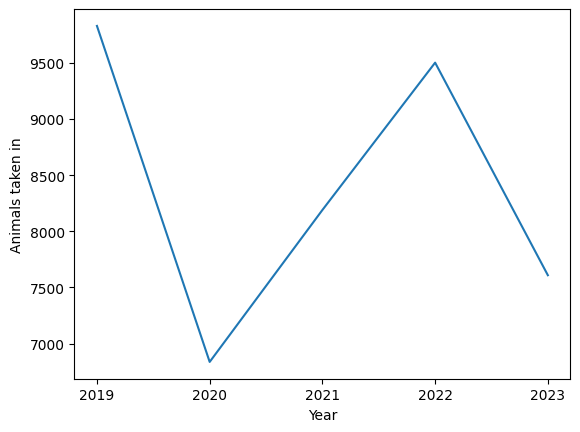

In [16]:
#line graph
#number of intakes over the years
#print(df.value_counts('indate year'), df.value_counts('outdate year'))
indate_df = df.value_counts('Indate Year').reset_index().sort_values(['Indate Year'])
indate_df.columns = ['Year', 'Count']

print(indate_df)

#change X axis to only show integers
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(indate_df['Year'], indate_df['Count'])
plt.xlabel('Year')
plt.ylabel('Animals taken in')
plt.show()

#significant decrease in 2020 (understandably)
#2023 seems lower than expected; the most recent dates in the data (at the time of creating this study) go to mid November 2023

In [ ]:
#bar graph
#how many of each animal did LMAS serve?
animal_count_df = df.value_counts('animaltype').reset_index()
animal_count_df.columns = ['animal', 'count']
animal_count_df.sort_values(['count'])

plt.bar(animal_count_df['animal'], animal_count_df['count'])
plt.xlabel('Animal')
plt.ylabel('Count')
plt.show()

In [ ]:
#what are the most common dog breeds in LMAS?

dog_df = df.loc[df['animaltype'] == 'DOG']

# print(dog_df.value_counts('intype'))
# print(dog_df.value_counts('outtype'))
print(dog_df.value_counts('breed').head(10))

# explore dog adoption stats
# adopted_dog_df = dog_df.loc[dog_df['outtype'] == 'ADOPTION']
# print(adopted_dog_df.value_counts('outsubtype'))



In [ ]:
#where are these animals coming from (ZIP codes)?

print(df.value_counts('sourcezipcode').head(10))
# significant majority of animals are from 40218, the same zip code as Lou Animal Services east campus
# Lou Animal Services west campus is 40215